In [1]:
from __future__ import division, print_function
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#from pystruct.models import GraphCRF

from disparity import cnn, util
from disparity.crf import get_neighboring_pairs

Using TensorFlow backend.


In [2]:
num_beliefs = 16

In [4]:
# load left and right images
image_left = np.array(Image.open('../data/test/tsukuba_L.png'))
image_right = np.array(Image.open('../data/test/tsukuba_R.png'))
height, width, _ = image_left.shape

# compute binocular disparity using CNN
energies = cnn.compute_energies(
    image_left, image_right, numDisparities=num_beliefs
)
disparity = np.argmin(energies, axis=2)

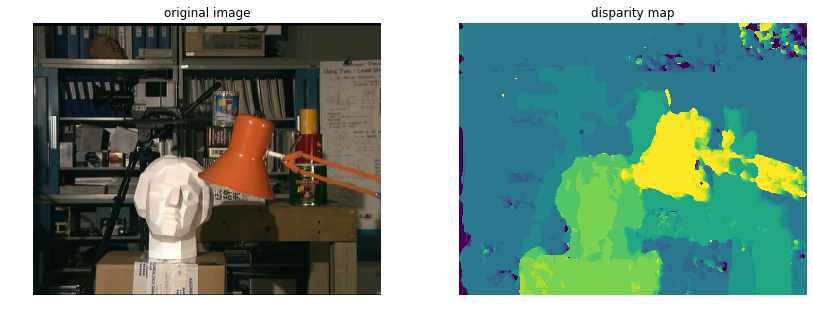

In [5]:
# visualize
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(image_right[:,:-num_beliefs])
axes[0].axis('off')
axes[0].set_title('original image')
axes[1].imshow(disparity[:,:-num_beliefs])
axes[1].axis('off')
axes[1].set_title('disparity map')
plt.show()

In [6]:
model = GraphCRF(
    n_states=num_beliefs, n_features=num_beliefs, inference_method='max-product',
    directed=True
)

NameError: name 'GraphCRF' is not defined

In [22]:
def unary_potential(x,y):
    return np.square(x-y)

def binary_potential(a,b,alpha=60.,beta=1.5):
    d = np.square(a-b)
    smooth = alpha*d/(d+beta)
    
    return smooth

In [23]:
unaries = np.zeros((num_beliefs, num_beliefs), dtype=np.float32)
binaries = np.zeros((num_beliefs, num_beliefs), dtype=np.float32)
for a in range(num_beliefs):
    for b in range(num_beliefs):
        unaries[a,b] = unary_potential(a,b)
        binaries[a,b] = binary_potential(a,b)
unaries = unaries.flatten()
binaries = binaries.flatten()

In [27]:
# IMPORTANT: negative sign here
w = -np.concatenate([unaries, binaries])

In [29]:
# one-hot-encode the observations
features = np.zeros((height*width, num_beliefs), dtype=np.float32)
features[np.arange(height*width), disparity.flatten()] = 1

In [30]:
# get list of edges
edges = get_neighboring_pairs(height, width)

In [31]:
y = model.inference(x=(features, edges), w=w)

In [32]:
disparity_p = y.reshape(height, width)

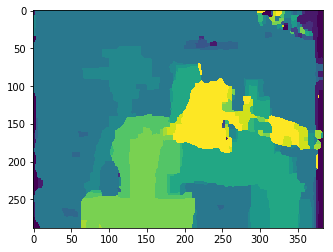

In [36]:
# visualize
plt.figure()
plt.imshow(disparity_p)
plt.show()